Authors:

Lijing Wang (lijing52@stanford.edu)

Alex Miltenberger (ammilten@stanford.edu, ammilten@gmail.com)

June, 2022

In [1]:
from scipy.constants import G, pi
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import pymc3 as pm
from theano import *
import theano
import theano.tensor as tt
import scipy.stats as st

np.random.seed(1)

In [2]:
# Gravity forward model
def forward_gravity_model(m,x):
    z, a, rho = m
    gz = (4/3)*G*pi*np.power(a,3)*rho*z/np.power((x**2+z**2),(3/2))*1e5
    return gz  

#  def forward_gravity_model(m,x):
#     z, a, rho = m
#     gz = (4/3)*G*pi*np.power(a,3)*rho*z/np.power((x**2+z**2),(3/2))*1e5
#     return gz     

In [3]:
# Test this forward model
m_true = [125, 100, 2000] # z, a, rho, just a test
# m_true = np.array([[2000, 100, 125]])

x = np.linspace(-200,200,21)
gz = forward_gravity_model(m_true, x)



sig = 0.05
gz_obs = st.multivariate_normal(mean=gz, cov=np.diag((gz*sig)**2)).rvs(1)
# gz_obs[3] = gz_obs[3] + 0.5


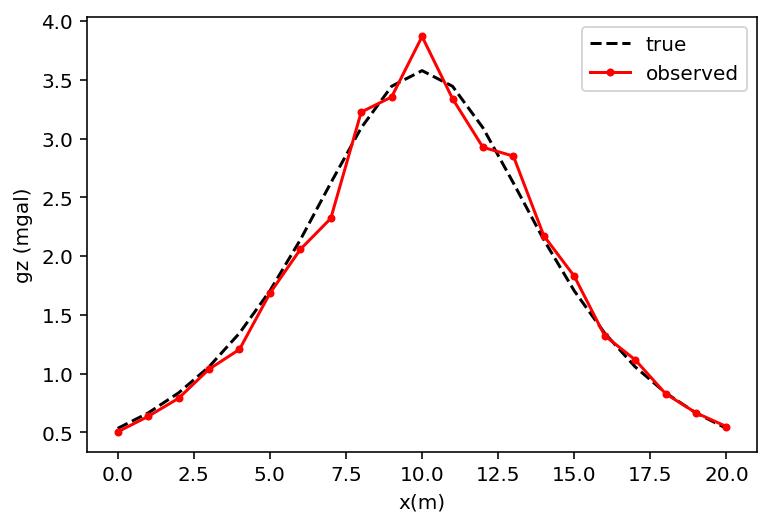

In [4]:
plt.plot(gz,'--',color = 'black',label = 'true')
plt.plot(gz_obs,'.-',color = 'red',label = 'observed')
plt.xlabel('x(m)')
plt.ylabel('gz (mgal)')
plt.legend()

# MCMC, with Gaussian likelihood assumption 

In [5]:
def McMC(forward_gravity_model, gz_obs,sigma, tuning_step = 1000):
    basic_model = pm.Model()

    with basic_model:
        # Priors for unknown model parameters
        z = pm.Uniform("z", lower = prior_min[0], upper=prior_max[0])
        a = pm.Uniform("a", lower = prior_min[1], upper=prior_max[1])
        rho = pm.Uniform("rho", lower = prior_min[2], upper=prior_max[2])
        
        obs_diff = forward_gravity_model([z,a,rho],x)-gz_obs.reshape(-1)

        sigma = sigma
        cov = np.eye(len(gz_obs))*sigma

        # Likelihood
        Y_obs = pm.MvNormal("d_obs", mu=0, cov=cov, observed=obs_diff)

    with basic_model:
        trace = pm.sample(10000, chains = 1,cores = 1, tune = tuning_step, target_accept = 0.95,
                          start={'z': np.array(125), 'a': np.array(100),
                                 'rho': np.array(2000)}, return_inferencedata=False) # [125, 100, 2000]
    
    return trace

In [6]:
prior_min = np.array([25,70,1000])
prior_max = np.array([200,200,7000])
trace = McMC(forward_gravity_model, gz_obs, sigma = 0.03, tuning_step = 2000)
theta_pos = np.array([trace['z'],trace['a'],trace['rho']]).T

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [rho, a, z]


Sampling 1 chain for 2_000 tune and 10_000 draw iterations (2_000 + 10_000 draws total) took 299 seconds.
The acceptance probability does not match the target. It is 0.9012692275057896, but should be close to 0.95. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


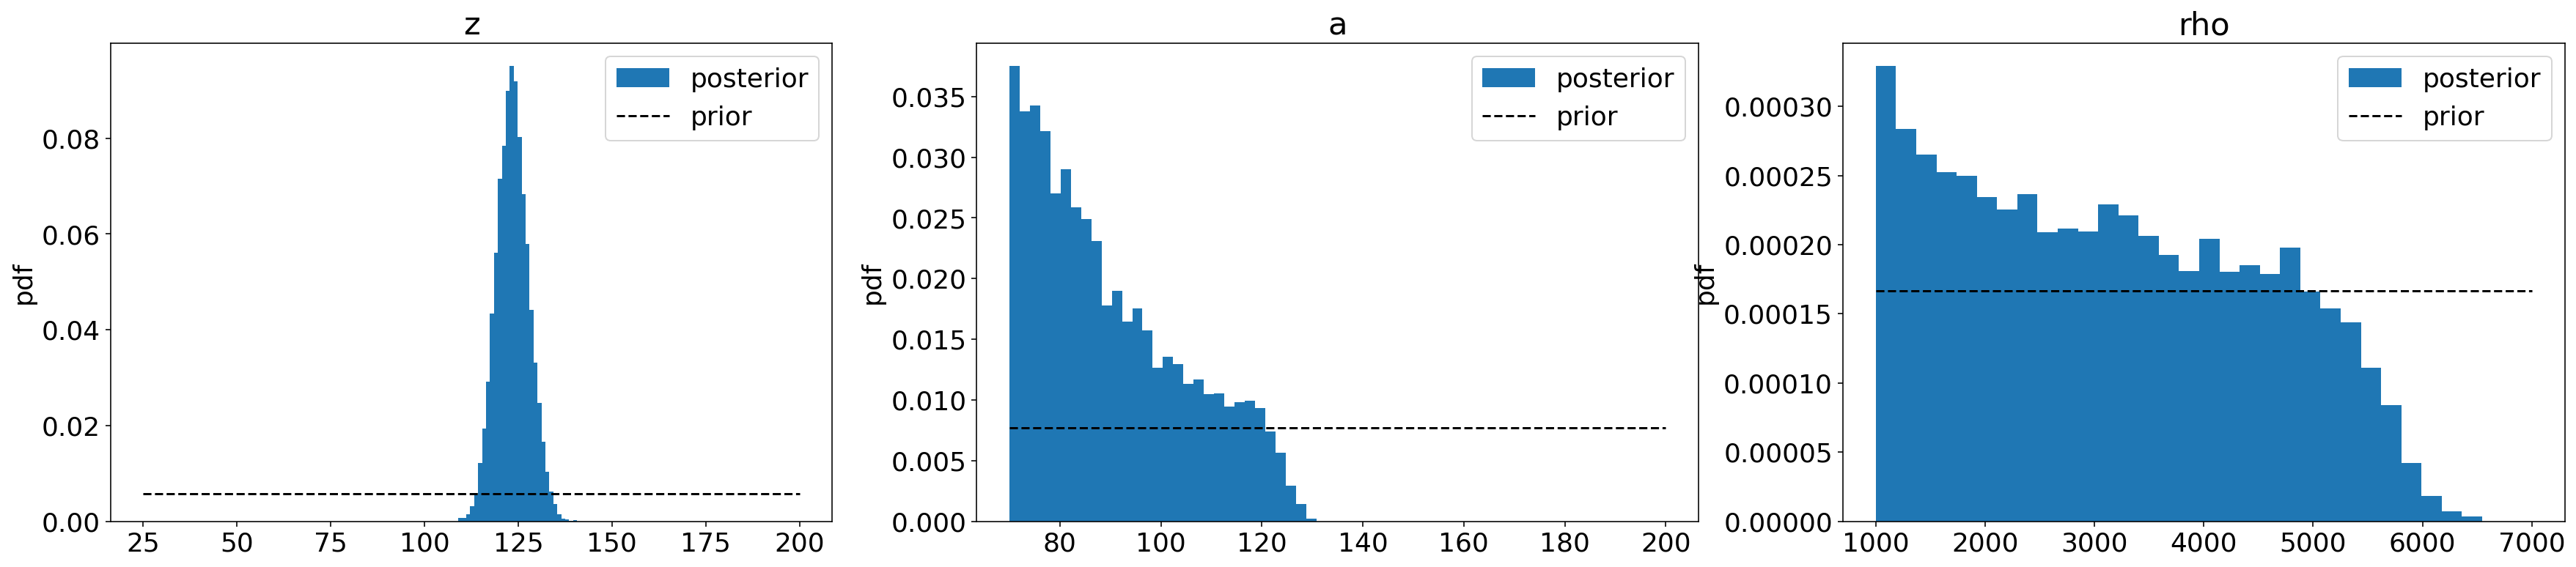

In [7]:
matplotlib.rcParams.update({'font.size': 18})
theta_name = ['z','a','rho']
num_theta = 3
plt.figure(figsize=[30,6])
for i in np.arange(num_theta):
    ax = plt.subplot(1, 3, i+1)
    ax.hist(theta_pos[:,i],density=True, bins = 30,label = 'posterior')
    ax.hlines(y = 1/(prior_max[i]-prior_min[i]), xmin = prior_min[i], xmax = prior_max[i],linestyles='--',label = 'prior',color = 'black')
    ax.legend()
    ax.set_title(theta_name[i])
    ax.set_ylabel('pdf')

In [8]:
d_pos = np.array([forward_gravity_model(theta_pos[i,:],x) for i in range(theta_pos.shape[0])])

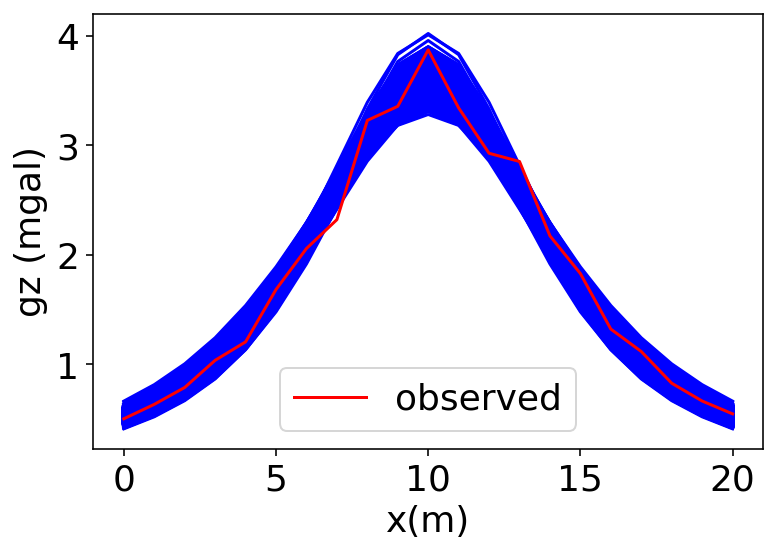

In [9]:
plt.plot(d_pos.T,color= 'blue')
plt.plot(gz_obs,color = 'red',label = 'observed')
plt.xlabel('x(m)')
plt.ylabel('gz (mgal)')
plt.legend()

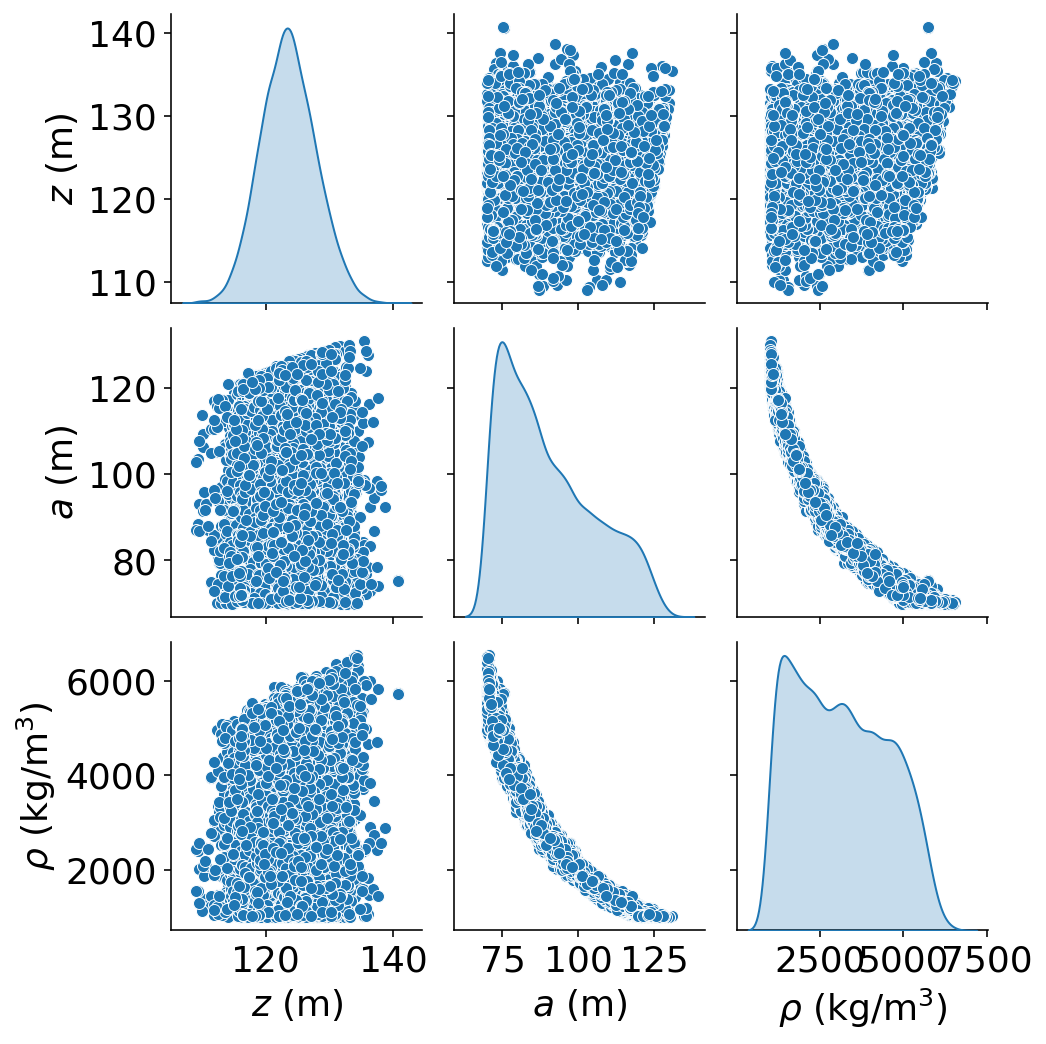

In [10]:
import seaborn as sns
cols = [r'$z$ (m)', r'$a$ (m)', r'$\rho$ (kg/m$^3$)']
theta_pos = pd.DataFrame(theta_pos, columns = cols)
sns.pairplot(theta_pos[cols], kind = 'scatter', diag_kind='kde')

In [11]:
theta_pos.to_csv('MCMC_samples.csv')

In [12]:
theta_pos

,$z$ (m),$a$ (m),$\rho$ (kg/m$^3$)
0,126.674878,91.404448,2715.155201
1,125.582784,89.157313,2777.600710
2,122.687330,99.500969,2017.615668
3,123.020190,95.789851,2196.887431
4,125.632789,108.815213,1540.015942
...,...,...,...
9995,123.289515,113.940270,1318.156516
9996,130.296880,83.930851,3595.561197
9997,125.467231,104.479564,1771.593380
9998,125.461262,97.933823,2052.552648


In [13]:
trace.__dir__()
np.mean(trace.get_sampler_stats(stat_name='mean_tree_accept'))

0.9012692275057896